# Mini U-net
- Semantic segmentation for (small) images, with included learned uncertainty estimation
    -  There is separate script for semantic segmentation with learned uncertainty estimation
- Loss based on (Sørensen -)Dice coefficient is utilized due to favorable properties related to unbalanced pixel counts.
    -  Milletari, F., Navab, N. & Ahmadi, S.-A. (2016) ‘V-Net: Fully Convolutional Neural Networks for Volumetric Medical Image Segmentation’, in 2016 Fourth International Conference on 3D Vision (3DV). 2016 Fourth International Conference on 3D Vision (3DV), pp. 565–571. Available at: https://doi.org/10.1109/3DV.2016.79.
- This implementation also takes inspiration from
    -  Wu, S., Heitzler, M. & Hurni, L. (2022) ‘Leveraging uncertainty estimation and spatial pyramid pooling for extracting hydrological features from scanned historical topographic maps’, GIScience & Remote Sensing, 59(1), pp. 200–214. Available at: https://doi.org/10.1080/15481603.2021.2023840.

### The main idea
- Learns to segment areas of interest with fewer parameters than normal U-net, which reduces the need for training data and also the risk for overfitting

### Notes
- Current implementation is experimental and needs further optimization, testing and functionality
    - IMPORTANT The possibility to input a large geotiff in addition to training and testing data should be implemented. In that case the trained model wouldbe used to predict the whole area in a sliding window type of setup. Then it should be parsed back together to create output prediction and uncertainty estimate geotiffs for the whole area. This tool should not be included in the toolkit before that can be done.
    - For example, hyperparameter tuning should be automatized
    - Dice coefficient and Intersection over Union should be implemented as metric to measure the goodness of model
        - custom metrics are needed due to the unusual shape of the output
    -  Data suffling should maybe moved to data sampling side
        - Leave one out cross validation should also be implemented and integrated with data sampling, so that user has reliable tools to estimate possible (likely) overfitting
        - current implementation with data sampler does not create reliable test data, because one occurence features multiple times in data with different croppings.
        - The other option is to take out all the times one of the features occurs before suffling and keep data sampling as is 
- The current implementation only works with binary classes (0 and 1)

- Image size should be at least 32 x 32 pixels or larger power of 2 (or at least divisible three times with 2, after which size should be at least 3 x 3)
- Using either data from automatic sampling function or user's own data should be given as an option

In [1]:
# Options
# Random seed, TODO randomness should be moved to the data generation side
seed = 1
"""Geotiff image folder, containing the data.
Image size should be at least 32 x 32 pixels or larger power of 2 (or at least divisible three times with 2, after which size should be at least 3 x 3)
It should be given as an option to use either data from automatic sampling function or user's own data
"""
img_dir = "/home/iiro/Documents/Työ/data/testing/cnn/data/buffer_images"
# Geotiff image folder, containing the labels, where 1 means wanted class and zero means background. Should be the same size as images
label_dir = "/home/iiro/Documents/Työ/data/testing/cnn/data/buffer_labels"

# Too many epochs results in overfitting
epoch_count = 6

batch_size = 16

In [2]:
import tensorflow as tf
import rasterio
import glob
import os
import random

import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt


from tensorflow import keras
from keras import backend as K
from keras.optimizers import SGD
from tensorflow.keras.layers import Activation, Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, BatchNormalization, Dropout, concatenate, Multiply, RandomFlip, RandomRotation, RandomTranslation, RandomCrop
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K 
from tensorflow.keras import losses
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping

2023-10-11 13:47:03.620101: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
def img_loader(image_dir):
    """ Fetches all the tiffs in the given directory and creates a numpy ndarray of shape (image_count, bands, width, height) from them.
    Returns the array, tiff metadata as list and associated nodatamasks in shape (image_count, width, height)
    Tiffs are assumed to be same size and named {number}.tif starting from 0
    """
    # fetching the filepaths
    paths = []
    metas = []
    for path in glob.glob(os.path.join(image_dir, "*.tif")):
        paths.append(path)
       
    img_count = len(paths)

    # Getting the size of the images
    with rasterio.open(paths[0]) as src:
        meta = src.meta.copy()
    image_width = meta['width']
    image_height = meta['height']
    
    nodata_masks = np.empty((img_count, image_width, image_height), dtype='bool')     
    for i in range(img_count):
        path = os.path.join(image_dir, str(i) + ".tif")
        with rasterio.open(path) as src:
            meta = src.meta.copy()
            metas.append(meta)
            # Note: rasterio returns shape (bands, width, height)
            img_arr = np.empty((meta['count'], image_width, image_height,), dtype=meta['dtype'])
            
            # Normalizing the data between 0 and 1. Differing bands have different values so they are processed separately
            # Rasterio follows GDAL convention and starts band numbering from 1
            for band_n in range(1, meta['count'] + 1):
                """There might be slight differences in the nodatamasks between the bands, they are all ANDed together
                to create a mask that covers all the nodata patches in all bands.
                Therefore nodata processing needs to be inside this loop
                """
                nodata_mask = src.read_masks(band_n)
                """Changing the mask to reflect numpy convention instead of gdal.
                Invalid entries have a value of 1 or True, and valid have values of 0 or False. 
                """
                nodata_mask = nodata_mask == 0
                if band_n == 1: 
                    nodata_mask_full = nodata_mask
                else:
                    nodata_mask_full = np.logical_and(nodata_mask_full, nodata_mask, out=nodata_mask_full)

                #normalization
                band_arr = src.read(band_n)
                # Setting nodatamasks to zero
                band_arr[band_arr==-999999] = 0
                band_arr_masked = ma.masked_array(band_arr, mask=nodata_mask)
                minimum = band_arr_masked.min()
                maximum = band_arr_masked.max()
                band_arr = (band_arr_masked - minimum)/ (maximum-minimum)
                img_arr[band_n-1] = band_arr
                
        nodata_masks[i] = nodata_mask_full
        # Storing array needs to be created only on the first iteration. 
        # All images are assumed to be same size and dtype, so the meta of the first one is used
        if i==0:
            data_arr = np.empty((img_count, meta['count'], meta['width'], meta['height']), dtype=meta['dtype'])
        data_arr[i] = img_arr
      
    data_arr = np.moveaxis(data_arr, 1, -1)
    return data_arr, metas, nodata_masks

def label_loader(label_dir):
    """Fetches all the tiffs in the given directory and return a numpy ndarray of shape (image_count, width, height).
    The images are assumed to be same size and contain the labels with numbers showing classes. 
    The tiffs should have only one band,
    """
    # fetching the filepaths
    paths = []
    for path in glob.glob(os.path.join(label_dir, "*.tif")):
        paths.append(path)
       
    img_count = len(paths)
    
    # Getting the size of the images
    with rasterio.open(paths[0]) as src:
        meta = src.meta.copy()
    nodata_value = meta['nodata']
    data_arr = np.empty((img_count, meta['count'], meta['width'], meta['height']), dtype='float32')
    
    for i in range(img_count):
        path = os.path.join(label_dir, str(i) + ".tif")
        with rasterio.open(path) as src:
            img_arr = src.read(1)
        #TODO add nodata handling. It could be a good idea to add 1 to the values and set the nodata pixel value as 0  
        # Or maybe nodata as zeros is just fine
        img_arr[img_arr == 255] = 0
        # moving band count(1) to last place
        img_arr = img_arr.astype('float32')  
        data_arr[i] = img_arr
    data_arr = np.moveaxis(data_arr, 1, -1)
    return data_arr, nodata_value

def keras_dice_coefficient(prediction, true_label):
    numerator = 2 * tf.reduce_sum(prediction * true_label)
    divisor = tf.reduce_sum(prediction ** 2) + tf.reduce_sum(true_label ** 2)
    return numerator / divisor

def keras_dice_loss(prediction, true_label):
    DC = keras_dice_coefficient(prediction, true_label)
    dice_loss = 1 -  DC
    return dice_loss
    
# Multi-channel autoencoder (modality determines the number of channels)
def build_autoencoder_multichannel_skip(resolution, modality, dropout=0.2, regularization=0):
    # List to hold all input layers
    input_img = Input(shape=(resolution, resolution, modality))
    
    # Encoder paths for each image
    encoded_imgs = []
    skip_connections = []
    
	# Encoder block 1, 32 res
    x = Conv2D(32, (3, 3), padding='same', kernel_regularizer=l1(regularization))(input_img)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(32, (3, 3), padding='same', kernel_regularizer=l1(regularization))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    skip_connections.append(x)
    x = MaxPooling2D((2, 2), padding='same')(x) 

    # Encoder block 2, 16 res
    x = Conv2D(64, (3, 3), padding='same', kernel_regularizer=l1(regularization))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same', kernel_regularizer=l1(regularization))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    skip_connections.append(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

	# Encoder block 3, 8 x 8 res
    x = Conv2D(128, (3, 3), padding='same', kernel_regularizer=l1(regularization))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropout)(x)
    x = Conv2D(128, (3, 3), padding='same', kernel_regularizer=l1(regularization))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    skip_connections.append(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    encoded_imgs.append(x)
    
    
    # Decoder
    
    # Decoder block 1
    skip_1 = skip_connections[-1]  # Corresponding output from the encoder
    x = Dropout(dropout)(x)
    x = Conv2D(256, (3, 3), padding='same', kernel_regularizer=l1(regularization))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same', kernel_regularizer=l1(regularization))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = UpSampling2D((2, 2))(x)
    x = concatenate([x, skip_1], axis =-1)
    
    # Decoder block 2
    skip_2 = skip_connections[-2]  # Corresponding output from the encoder
    x = Conv2D(128, (3, 3), padding='same', kernel_regularizer=l1(regularization))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropout)(x)
    x = Conv2D(64, (3, 3), padding='same', kernel_regularizer=l1(regularization))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = UpSampling2D((2, 2))(x)
    x = concatenate([x, skip_2], axis =-1)

    # Decoder block 2
    skip_3 = skip_connections[-3]  # Corresponding output from the encoder
    x = Conv2D(64, (3, 3), padding='same', kernel_regularizer=l1(regularization))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropout)(x)
    x = Conv2D(32, (3, 3), padding='same', kernel_regularizer=l1(regularization))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = UpSampling2D((2, 2))(x)
    x = concatenate([x, skip_3], axis =-1)
    
    # Output Layer
    x = Conv2D(32, (3, 3), padding='same', kernel_regularizer=l1(regularization))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropout)(x)
    x = Conv2D(32, (3, 3), padding='same', kernel_regularizer=l1(regularization))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # activation with normalized tanh should be considered because it has steeper gradients
    decoded = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x)
    # Uncertainty output
    
    
    # Create the model
    autoencoder_multi_channel = Model(input_img, decoded)
    
    return autoencoder_multi_channel

In [4]:
data_arr, metas, nodata_masks = img_loader(img_dir)
# Labels, which contain
label_arr, label_nodata_value = label_loader(label_dir)
# TODO move the shuffling to the image generator side so that other metadata doesn't need to be shuffled identically to data when constructing 

# Suffling the images and the labels, because currently the sampler (data creator, separate script) creates 
rng = np.random.default_rng(seed=seed)
rng.shuffle(data_arr, axis=0)
# Resetting the rng because we need same suffling for labels
rng = np.random.default_rng(seed=seed)
rng.shuffle(label_arr, axis=0)

image_count = data_arr.shape[0]
train_count = round(image_count * 0.7)
test_count = image_count - train_count
training_data = data_arr[0:train_count]
training_labels = label_arr[0:train_count]
test_data = data_arr[train_count:]
test_labels = label_arr[train_count:]

band_count = data_arr.shape[-1]

In [5]:
# For developing
unique, counts = np.unique(label_arr, return_counts=True)
imbalance = dict(zip(unique, counts))
occurence_count = imbalance[1]
total_count = label_arr.size
print(occurence_count)
print(total_count)
print(band_count)

20205
2051072
10


(2003, 32, 32, 10)


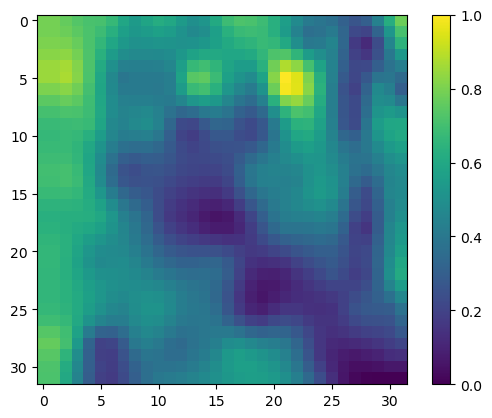

In [6]:
#plt.imshow(nodata_masks[32])
plt.imshow(training_data[1,:,:, 6], vmin=0, vmax=1)
plt.colorbar()
print(data_arr.shape)

float32
1.0
(2003, 32, 32, 1)


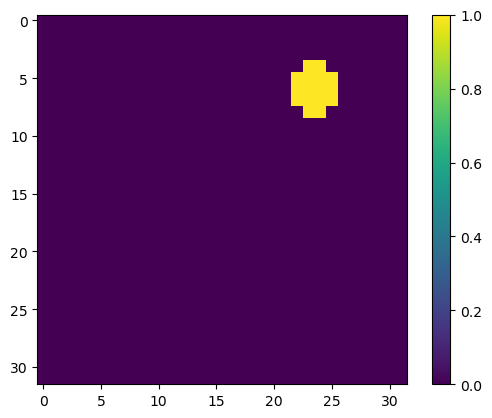

In [7]:
plt.imshow(np.squeeze(training_labels[1]), vmin=0, vmax=1)
plt.colorbar()
print(label_arr.dtype)
print(label_arr.max())
print(label_arr.shape)

In [8]:
# Training is stopped if validation loss hasn't improved in 3 epochs
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
# Data augmentation
mode = None
model = Input(shape=(32, 32, 10))
model = RandomFlip()(model)
model = RandomCrop(28, 28)(model)
model = RandomRotation((-0.3, 0.3))(model)
# mini-unet
model = build_autoencoder_multichannel_skip(32, 10)

model.compile(
    optimizer=SGD(learning_rate=0.008, decay=1e-6, momentum=0.9),
    loss=keras_dice_loss)

model.summary()

history = model.fit(training_data, training_labels, batch_size=batch_size, epochs=epoch_count, validation_split=0.3, callbacks=[callback])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 10)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   2912        ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [9]:
model.evaluate(test_data, test_labels)
prediction = model.predict(test_data)
train_prediction = model.predict(training_data)

44/44 [==============================] - 2s 41ms/step


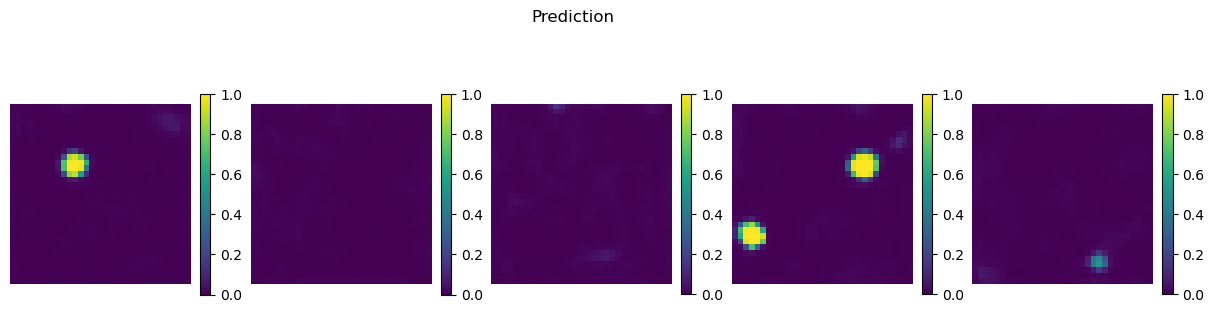

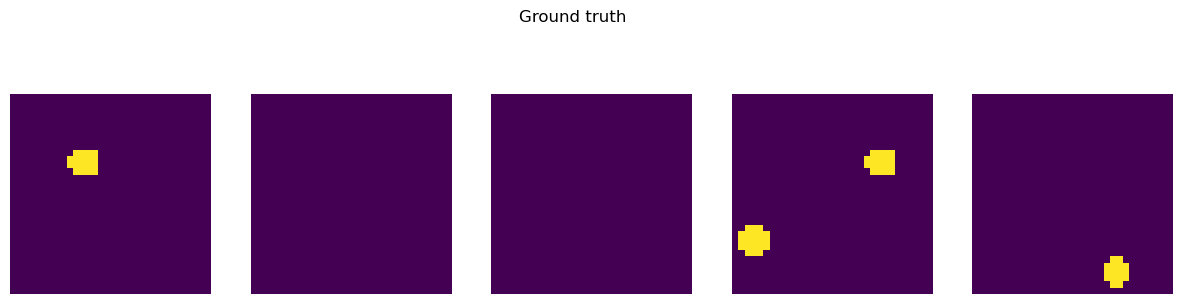

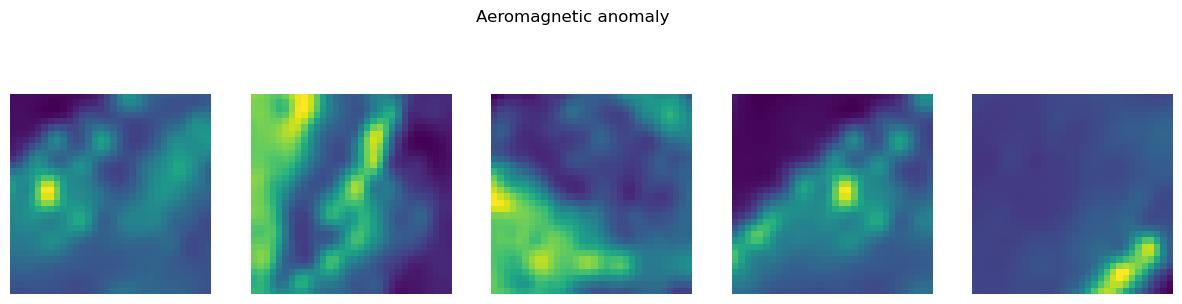

In [22]:
pltsize = 3
index = random.randint(5, test_count)
# Predictions
plt.figure(figsize=(5*pltsize, 3 * pltsize))
for j, i in enumerate(range(index - 5, index)):
    plt.subplot(1,5,j+1)
    plt.axis('off')
    plt.suptitle('Prediction', y=0.7)
    plt.imshow(prediction[i,:,:], vmin=0, vmax=1)
    plt.colorbar(fraction=0.05)
# Ground truth
plt.figure(figsize=(5*pltsize, 3 * pltsize))
for j, i in enumerate(range(index - 5, index)):
    plt.subplot(1,5,j+1)
    plt.axis('off')
    plt.suptitle('Ground truth', y=0.7)
    plt.imshow(test_labels[i], vmin=0, vmax=1)

plt.figure(figsize=(5*pltsize, 3 * pltsize))
for j, i in enumerate(range(index - 5, index)):
    plt.subplot(1,5,j+1)
    plt.axis('off')
    plt.suptitle('Aeromagnetic anomaly', y=0.7)
    plt.imshow(test_data[i, :, :, 8], vmin=0, vmax=1)

### TODO 
- The outputs need to be changed back to geotiffs with the saved data and nodata masks
- The current implementation makes this a bit hard since suffling the images is done after separating the images and metadata. The suffling should be moved to data generation side or the images should be unsuffled